## Binary classification with CNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed and tokenized. 
1. `data_processing` notebook loads raw data and prepares training,validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model

### 1. Import libraries

In [2]:
from modules.bert_module import *
from modules.path_module import *
import os
import joblib
from modules.lipcot_module import LiPCoTdata
from transformers import BertTokenizer
from hugtokencraft import editor # type: ignore
import torch
import numpy as np

### 2. Load tokenized data

In [3]:
train_data=joblib.load(os.path.join(tokenized_data_savepath,"train_data.joblib"))
test_data=joblib.load(os.path.join(tokenized_data_savepath,"test_data.joblib"))
val_data=joblib.load(os.path.join(tokenized_data_savepath,"val_data.joblib"))

### 3. Prepare data for CNN
- We extract only the signal data and labels from dataset for CNN
- We train using the training set and save the model that gives the best performance on the validation set

In [4]:
def prepare_cnn_data(lkdataset):
    signal_data=[]
    labels=[]
    for lkdata in lkdataset:
        signal=lkdata.data # (signal x chan) matrix
        signal=np.transpose(signal) #(Chan x Signal Length) matrix
        signal_tensor=torch.from_numpy(signal).float() # tensor
        signal_data.append(signal_tensor)
        if lkdata.label==0:
            newlabel=torch.tensor([0,1]).float()
        else:
            newlabel=torch.tensor([1,0]).float()
        labels.append(newlabel)
    return signal_data,labels

train_sigdata,train_label=prepare_cnn_data(val_data)
val_sigdata,val_label=prepare_cnn_data(train_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. CNN model
Let's define our baseline CNN architecture which has one conv layer and one FC layer

In [115]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self,chan_total,signal_length):
        super(CNN_Model, self).__init__()
        self.stride=5#2
        self.k_val=50#100
        # conv: (chan x signal)--> (chan x signal/stride)
        self.conv1 = nn.Conv1d(in_channels=chan_total, out_channels=chan_total, kernel_size=2*self.k_val+self.stride, stride=self.stride,padding=self.k_val) #k=lpc order ?#oc=2,k=4
        # pool: (chan x signal/stride) --> (chan x 1)
        self.pool1 = nn.AvgPool1d(kernel_size=int(signal_length/self.stride))
        self.input_s=int(chan_total)
        self.fc = nn.Linear(self.input_s, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool1(x)
        x = x.view(-1, self.input_s)
        x=self.fc(x)
        return x

Other deeper architectures are defined below which are not used for now

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x += residual  # Element-wise addition
        x = F.relu(x)
        return x
    

class FC_Classification(nn.Module):
    def __init__(self, num_classes,input_size):
        super(FC_Classification, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(input_size, input_size)
        self.residual_block = ResidualBlock(input_size)
        self.classifier = nn.Linear(input_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Convert input_ids to float before matrix multiplication
        input_ids_float = input_ids.float()
        x = self.fc(input_ids_float)
        x = F.relu(x)
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits
    
class CNN_Model_deep(nn.Module):
    def __init__(self,chan_total,signal_length):
        super(CNN_Model, self).__init__()
        self.stride=1
        self.k_val=50
        # input 62 x max_length
        self.conv1 = nn.Conv1d(in_channels=chan_total, out_channels=chan_total, kernel_size=2*self.k_val+1, stride=self.stride,padding=self.k_val) #k=lpc order ?#oc=2,k=4
        # input 62 x max_length
        self.pool1 = nn.AvgPool1d(kernel_size=signal_length)
        # input 62 x max_length/10
        self.conv2 = nn.Conv1d(in_channels=chan_total, out_channels=chan_total, kernel_size=2*4+1, stride=1,padding=4)
        # input 62 x max_length/10
        self.pool2 = nn.AvgPool1d(kernel_size=10)
        # input 62 x max_length/100
        self.conv3 = nn.Conv1d(in_channels=chan_total, out_channels=chan_total, kernel_size=2*4+1, stride=1,padding=4)
        # input 62 x max_length/100
        self.pool3 = nn.AvgPool1d(kernel_size=5)
        # input 62 x max_length/500
        #self.input_s=int(chan_total*signal_length/(5*10*10))
        self.input_s=int(chan_total/(self.stride))
        self.fc1 = nn.Linear(self.input_s, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
        self.fc = nn.Linear(self.input_s, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool1(x)
        #x = F.relu(self.conv2(x))
        #x = self.dropout(x)
        #x = self.pool2(x)
        #x = F.relu(self.conv3(x))
        #x = self.dropout(x)
        #x = self.pool3(x)
        x = x.view(-1, self.input_s)
        x=self.fc(x)
        #x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        #x = torch.sigmoid(self.fc3(x))
        #x=self.fc3(x)
        return x


### 5. Initialize CNN model

In [116]:
from tqdm import tqdm
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = CNN_Model(n_chan,n_datalength)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [117]:
batch_size = 2#1
num_epochs = 100
lrate=1e-5
patience=20
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lrate)
cnn_modelfullpath=os.path.join(cnn_modelpath,'cnn.pt')

### 7. Prepare data

In [118]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 8. Train model

In [119]:
def evaluate_binary_accuracy(model,eval_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in eval_loader:
            in_data=batch[0]
            in_label=batch[1]

            # Forward pass
            logits = model(in_data) 
            # Convert logits to probabilities using sigmoid activation
            probs = torch.sigmoid(logits)
            probs_normalized = probs / probs.sum(dim=1, keepdim=True)

            # Convert probabilities to binary predictions (0 or 1)
            preds = (probs_normalized > 0.5).int()

            all_scores.extend(probs_normalized.tolist())
            all_preds.extend(preds.tolist())
            all_labels.extend(in_label.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy*100,    all_preds,  all_labels  ,all_scores

torch.manual_seed(42)

# Training loop
num_batches = len(train_loader)
best_val_accuracy=-1
average_epoch_loss_all=[]
acc_train_all=[]
acc_val_all=[]

tr_est_temp=[]
tr_labels_temp=[]
tr_scores_temp=[]

v_est_temp=[]
v_labels_temp=[]
v_scores_temp=[]

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Use tqdm to create a progress bar for the training loop
    for batch_data, batch_labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()
        output = model(batch_data)
        probs = torch.sigmoid(output)
        probs_normalized = probs / probs.sum(dim=1, keepdim=True)
        loss = criterion(probs_normalized, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate and print average epoch loss
    average_epoch_loss = total_loss / num_batches
    average_epoch_loss_all.append(average_epoch_loss)
    #calculate accuracy perf
    accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
    v_accuracy, val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
    # Switch back to training mode for the next epoch
    model.train()
    # collect eval results
    acc_train_all.append(accuracy)
    acc_val_all.append(v_accuracy)

    tr_est_temp.extend([tr_est])
    tr_labels_temp.extend([tr_labels])
    tr_scores_temp.extend([tr_scores])

    v_est_temp.extend([val_est])
    v_labels_temp.extend([val_labels])
    v_scores_temp.extend([val_scores])

    #print(f'Epoch {epoch + 1} - Average Loss: {average_epoch_loss:.4f} - Train acc: {accuracy:.2f} - Validation acc: {v_accuracy:.2f}')

    # Check if validation accuracy has improved
    if v_accuracy > best_val_accuracy:
        best_val_accuracy = v_accuracy
        torch.save(model.state_dict(),cnn_modelfullpath) # Save the model state
        print(f'model state saved with validation accuracy: {best_val_accuracy:.4f}')
        counter = 0  # Reset counter if accuracy improved
    else:
        counter += 1  # Increment counter if accuracy did not improve

    # Check if patience limit reached
    if counter >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation accuracy did not improve for {patience} epochs.')
        break

Epoch 1/100: 100%|██████████| 69/69 [00:01<00:00, 50.14it/s]


model state saved with validation accuracy: 65.2174


Epoch 2/100: 100%|██████████| 69/69 [00:01<00:00, 59.02it/s]


model state saved with validation accuracy: 65.5280


Epoch 3/100: 100%|██████████| 69/69 [00:01<00:00, 56.62it/s]


model state saved with validation accuracy: 66.1491


Epoch 4/100: 100%|██████████| 69/69 [00:01<00:00, 61.13it/s]


model state saved with validation accuracy: 67.3913


Epoch 5/100: 100%|██████████| 69/69 [00:01<00:00, 58.39it/s]


model state saved with validation accuracy: 68.0124


Epoch 10/100: 100%|██████████| 69/69 [00:01<00:00, 63.12it/s]


model state saved with validation accuracy: 73.6025


Epoch 16/100: 100%|██████████| 69/69 [00:01<00:00, 58.86it/s]


model state saved with validation accuracy: 76.0870


Epoch 22/100: 100%|██████████| 69/69 [00:01<00:00, 48.09it/s]


model state saved with validation accuracy: 77.6398


Epoch 23/100: 100%|██████████| 69/69 [00:01<00:00, 54.06it/s]


model state saved with validation accuracy: 78.2609


Epoch 25/100: 100%|██████████| 69/69 [00:01<00:00, 58.00it/s]


model state saved with validation accuracy: 79.1925


Epoch 36/100: 100%|██████████| 69/69 [00:01<00:00, 59.27it/s]


model state saved with validation accuracy: 79.5031


Epoch 37/100: 100%|██████████| 69/69 [00:01<00:00, 52.80it/s]


model state saved with validation accuracy: 79.8137


Epoch 39/100: 100%|██████████| 69/69 [00:01<00:00, 59.22it/s]


model state saved with validation accuracy: 80.4348


Epoch 58/100: 100%|██████████| 69/69 [00:01<00:00, 50.71it/s]


model state saved with validation accuracy: 80.7453


Epoch 61/100: 100%|██████████| 69/69 [00:01<00:00, 60.86it/s]


model state saved with validation accuracy: 81.0559


Epoch 64/100: 100%|██████████| 69/69 [00:01<00:00, 57.59it/s]


model state saved with validation accuracy: 81.6770


Epoch 84/100: 100%|██████████| 69/69 [00:01<00:00, 53.64it/s]


Early stopping at epoch 84 as validation accuracy did not improve for 20 epochs.


### 9. Inspect training process

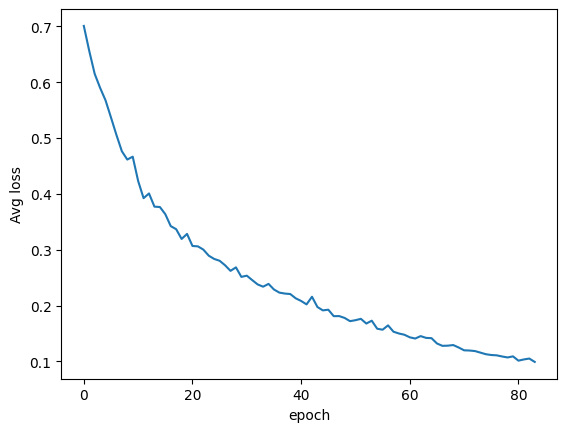

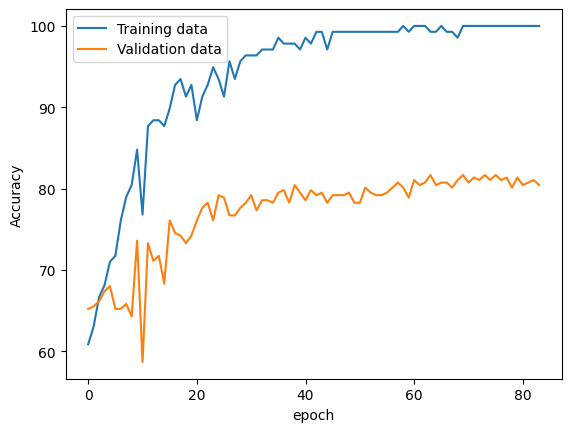

In [120]:
plt.figure()
plt.plot(average_epoch_loss_all)
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(acc_train_all,label='Training data')
plt.plot(acc_val_all,label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [121]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 99.2754
Confusion Matrix:
[[72  0]
 [ 1 65]]
Accuracy: 99.27536231884058
Sensitivity (Recall): 98.48484848484848
Specificity: 100.0
F1 Score: 0.9923664122137404
AUC Score: 1.0


Validation Binary Accuracy: 81.6770
Confusion Matrix:
[[147  21]
 [ 38 116]]
Accuracy: 81.67701863354037
Sensitivity (Recall): 75.32467532467533
Specificity: 87.5
F1 Score: 0.8095712861415754
AUC Score: 0.8629406307977737


Test Binary Accuracy: 70.6522
Confusion Matrix:
[[41  7]
 [20 24]]
Accuracy: 70.65217391304348
Sensitivity (Recall): 54.54545454545454
Specificity: 85.41666666666666
F1 Score: 0.6657645466847091
AUC Score: 0.8309659090909091
Completed
